With only two classes 

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
import os
import sys

# Add modules to path
sys.path.append('modules')

# Import our custom utilities
from data_utils import  create_data_loaders, plot_training_history, plot_confusion_matrix
from model_utils import CNNBaseline, train_model, evaluate_model

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")



In [2]:
import pandas as pd
import pickle

import json
def load_processed_data_v2():
    """Load preprocessed data ---   V2"""
    
    # Load dataframes
    train_df = pd.read_csv('processed_data_v2/train_df.csv')
    val_df = pd.read_csv('processed_data_v2/val_df.csv')
    test_df = pd.read_csv('processed_data_v2/test_df.csv')
    
    # Load label encoder
    with open('processed_data_v2/label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    
    # Load preprocessing config
    with open('processed_data_v2/preprocessing_config.json', 'r') as f:
        config = json.load(f)
    
    return train_df, val_df, test_df, label_encoder, config

In [3]:
## Load processed data is modified 
train_df, val_df, test_df, label_encoder, config = load_processed_data_v2()

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Number of classes: {config['num_classes']}")
print(f"Class names: {config['class_names']}")
print(f"Label encoder classes: {label_encoder.classes_}")

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    train_df, val_df, test_df, batch_size=config['batch_size']
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {config['batch_size']}")


Training samples: 945
Validation samples: 315
Test samples: 315
Number of classes: 2
Class names: ['ACK', 'BCC']
Label encoder classes: ['ACK' 'BCC']
Training batches: 30
Validation batches: 10
Test batches: 10
Batch size: 32


In [4]:
for images, targets, metadata in train_loader:
    print(f"Batch test successful:")
    print(f"Images shape: {images.shape}")
    print(f"Targets type: {type(targets)}, length: {len(targets)}")
    print(f"Sample targets: {targets[:3]}")
    print(f"Metadata type: {type(metadata)}")
    print(f"Metadata length: {len(metadata)}")
    break


Batch test successful:
Images shape: torch.Size([32, 3, 224, 224])
Targets type: <class 'list'>, length: 32
Sample targets: ['BCC', 'BCC', 'ACK']
Metadata type: <class 'list'>
Metadata length: 32


In [5]:
# Setup device and model configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create models directory
os.makedirs('models', exist_ok=True)

# Model configurations to test
model_configs = [
    {'name': 'resnet50_v2', 'model_name': 'resnet50_v2', 'pretrained': True}
]
# Training parameters
training_params = {
    'num_epochs': 50,
    'learning_rate': 0.001,
    'patience': 10
}

for key, value in training_params.items():
    print(f"{key}: {value}")


Using device: cuda
num_epochs: 50
learning_rate: 0.001
patience: 10


In [ ]:
# Create ResNet-34 model
resnet_model = CNNBaseline(
    num_classes=2,    # only 2 classes exist now
    model_name='resnet34',
    pretrained=True
)

print(f"ResNet-34 model created:")
print(f"Parameters: {sum(p.numel() for p in resnet_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in resnet_model.parameters() if p.requires_grad):,}")

ResNet-34 model created:
Parameters: 21,285,698
Trainable parameters: 1,026


In [22]:
# Train the model
resnet_history = train_model(
    model=resnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=training_params['num_epochs'],
    learning_rate=training_params['learning_rate'],
    device='cuda',
    patience=training_params['patience'],
    model_name='resnet34_baseline_v2',
    label_encoder=label_encoder 
)



Device available: True
Device: cuda
Starting training for 50 epochs...
Device: cuda
Model: resnet34
Parameters: 21,285,698


Epoch 1/50 [Train]:   3%|▎         | 1/30 [00:08<04:20,  8.97s/it, Loss=0.6286, Acc=62.50%]


KeyboardInterrupt: 

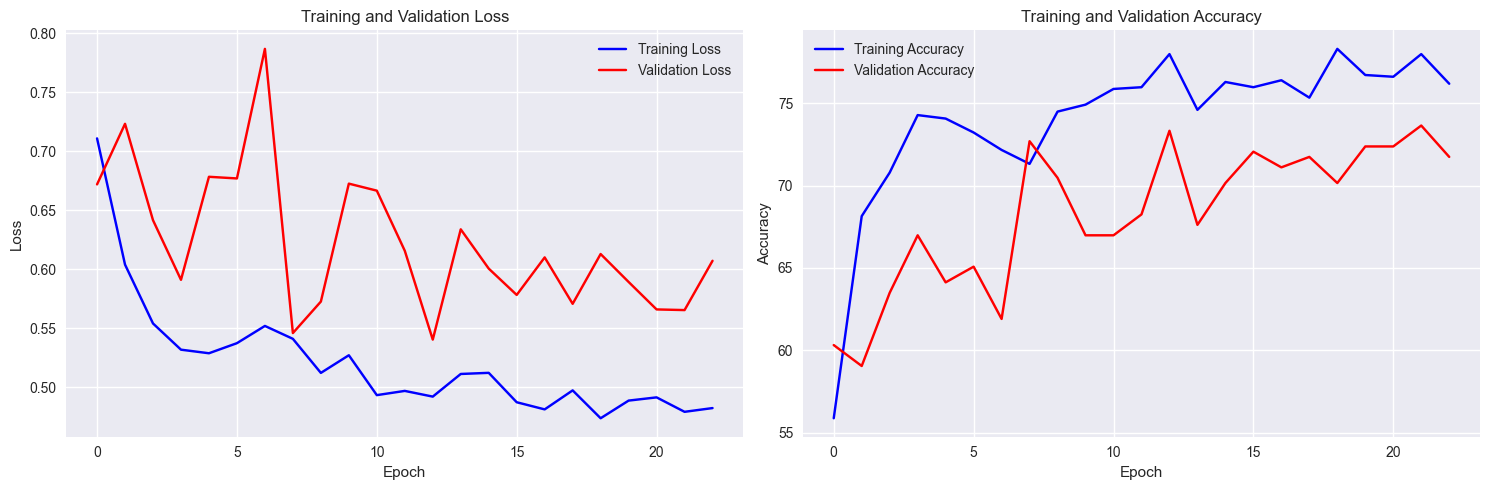

In [9]:
plot_training_history(resnet_history)

In [10]:
results = {}

model = resnet_model
model_name = 'resnet34_baseline_v2'
checkpoint_path = 'resnet34_baseline_v2_best.pth'

    
    # Load best weights
model.load_state_dict(torch.load(f'models/{checkpoint_path}', map_location=device))
    
    # Evaluate on test set
test_results = evaluate_model(
        model=model,
        test_loader=test_loader,
        device=device,
        class_names=config['class_names'],
        label_encoder=label_encoder  # Add label encoder
    )
    
results[model_name] = test_results

Evaluating model on test set...


Testing: 100%|██████████| 10/10 [00:35<00:00,  3.52s/it]

Test Results:
Accuracy: 0.7016 (70.16%)
Classification Report:
              precision    recall  f1-score   support

         ACK     0.7766    0.5000    0.6083       146
         BCC     0.6697    0.8757    0.7590       169

    accuracy                         0.7016       315
   macro avg     0.7231    0.6879    0.6837       315
weighted avg     0.7192    0.7016    0.6892       315



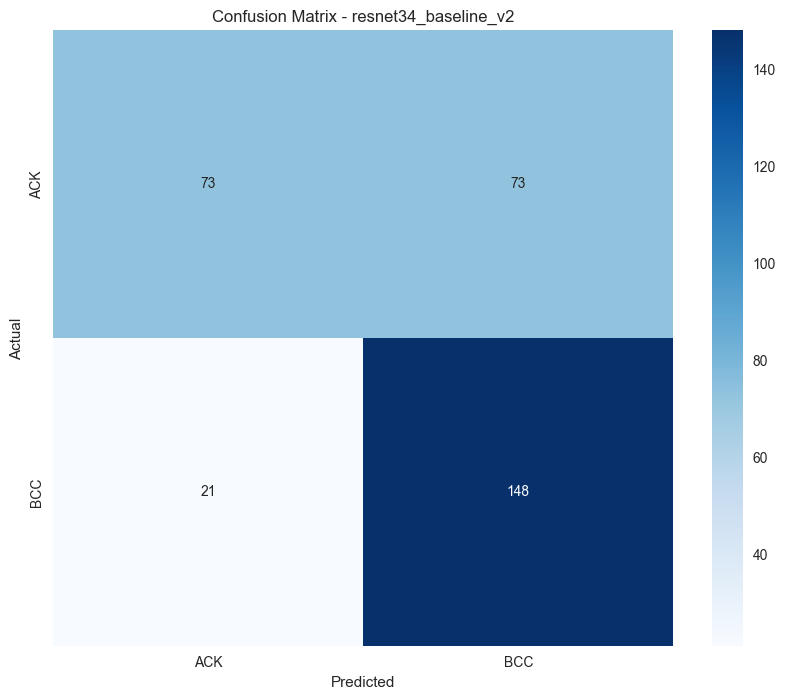

              precision    recall  f1-score   support

         ACK     0.7766    0.5000    0.6083       146
         BCC     0.6697    0.8757    0.7590       169

    accuracy                         0.7016       315
   macro avg     0.7231    0.6879    0.6837       315
weighted avg     0.7192    0.7016    0.6892       315



In [11]:
best_model_name = model_name
best_results = results[best_model_name]
y_true = best_results['targets']
y_pred = best_results['predictions']

# Plot confusion matrix
cm = plot_confusion_matrix(
    y_true, y_pred, 
    class_names=config['class_names'],
    title=f'Confusion Matrix - {best_model_name}'
)

# Print detailed classification report
report = classification_report(y_true, y_pred, target_names=config['class_names'], digits=4)
print(report)


The model still incines towards BCC. Lets use some other backbone, such as EfficientNet which is believed to generalize better to fine textures.

In [28]:
import torchvision.models as models

class EfficientNetBaseline(nn.Module):
    def __init__(self, num_classes, model_name= 'EfficientNet_Base', pretrained=True):
        super(EfficientNetBaseline, self).__init__()

        self.model_name = model_name

        # Load pretrained backbone
        if pretrained:
            self.backbone = models.efficientnet_b2(
                weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1
            )
        else:
            self.backbone = models.efficientnet_b2(weights=None)

        # Unfreeze last feature blocks
        for name, param in self.backbone.named_parameters():
            if "features.6" in name or "features.7" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Replace classifier
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier[1] =  nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)


In [29]:

# Create models directory
os.makedirs('models', exist_ok=True)

# Model configurations to test
model_configs = [
    {'name': 'efficient_net_base', 'model_name': 'efficient_net_base', 'pretrained': True}
]

# Training parameters
training_params = {
    'num_epochs': 50,
    'learning_rate': 0.001,
    'patience': 10
}

for key, value in training_params.items():
    print(f"{key}: {value}")

# Create ResNet-50 model
efficientNet_model = EfficientNetBaseline(
    num_classes= 2,
    pretrained=True
)

print(f"Parameters: {sum(p.numel() for p in resnet_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in resnet_model.parameters() if p.requires_grad):,}")




num_epochs: 50
learning_rate: 0.001
patience: 10
Parameters: 21,285,698
Trainable parameters: 1,026


In [30]:
#Train the model
efficientNet_history = train_model(
    model=efficientNet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=training_params['num_epochs'],
    learning_rate=training_params['learning_rate'],
    device='cuda',
    patience=training_params['patience'],
    label_encoder=label_encoder 
)

Device available: True
Device: cuda
Starting training for 50 epochs...
Device: cuda
Model: EfficientNet_Base
Parameters: 7,703,812


Epoch 1/50 [Train]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/50 [Val]: 100%|██████████| 10/10 [00:13<00:00,  1.39s/it, Loss=1.2163, Acc=81.90%]


Epoch 1/50:
Train Loss: 0.5218, Train Acc: 74.07%
Val Loss: 0.5234, Val Acc: 81.90%
LR: 0.000999
New best model saved! Val Acc: 81.90%


Epoch 2/50 [Train]:  43%|████▎     | 13/30 [00:36<00:48,  2.83s/it, Loss=0.3535, Acc=85.10%]


KeyboardInterrupt: 